# Setup and Logging

In [2]:
import pandas as pd
import numpy as np
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Professional logging setup as per project requirements
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Environment setup complete. Libraries imported.")

2026-01-12 16:07:36,785 - INFO - Environment setup complete. Libraries imported.


#  Data Loading


In [3]:
# Loading the pre-processed dataset specifically prepared for PCA
try:
    df_pca = pd.read_csv("../data/parkinsons_lifestyle_clinical_for_PCA.csv", index_col=0)
    logger.info(f"Dataset loaded successfully. Shape: {df_pca.shape}")
except FileNotFoundError:
    logger.error("Dataset file not found. Please check the file path.")

2026-01-12 16:07:36,815 - INFO - Dataset loaded successfully. Shape: (1304, 12)


# Feature Scaling (Standardization)

In [4]:
# PCA is scale-sensitive, so we must transform features to a common scale (Z-scores)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca)

logger.info("Feature scaling complete. Data is now normalized.")
print(scaled_data)
print(scaled_data.shape)

2026-01-12 16:07:36,869 - INFO - Feature scaling complete. Data is now normalized.


[[ 0.4243381  -1.54021073 -0.73693964 ...  0.63380325  0.7636974
   0.39494128]
 [-0.01727154 -1.66183946 -1.40492188 ... -0.18576771  1.12004033
   1.67429104]
 [-1.60706625 -1.64989677 -0.74220874 ...  0.22564631 -0.31717775
   1.34746082]
 ...
 [-0.28223733  0.87369234 -1.6281613  ... -0.34099839 -0.50237818
   0.1552456 ]
 [-0.45888119 -0.62951181 -0.71494632 ... -1.52216435  0.57349218
  -0.01909662]
 [-0.8121689  -1.45391936 -1.74902139 ... -1.72121748  1.7320011
  -0.54879482]]
(1304, 12)


#  Dimensionality Reduction (PCA)

In [5]:
# 1. Define the PCA model to reduce data into 3 components
pca = PCA(n_components=3)

# 2. Run the PCA on our standardized data
pca_results = pca.fit_transform(scaled_data)

# 3. Create a new DataFrame for organized results and easy visualization
df_pca_output = pd.DataFrame(
    data=pca_results,
    columns=['PC1', 'PC2', 'PC3'],
    index=df_pca.index  # Keeping the original Patient IDs as index
)
print(df_pca_output)
# Professional logging of the process
logger.info(f"PCA execution finished. Features reduced from {df_pca.shape[1]} to 3 components.")

2026-01-12 16:07:36,917 - INFO - PCA execution finished. Features reduced from 12 to 3 components.


           PC1       PC2       PC3
1     0.902693  0.371210  1.255069
2    -1.188047  0.194292  2.964120
3     1.051528 -0.904444  1.406671
7    -0.679002 -0.248408 -2.140275
8     1.179174  1.295203 -0.073477
...        ...       ...       ...
2098 -0.795839 -1.113644 -0.022461
2099  0.821855  0.738021 -0.265359
2101  0.390033 -0.218289 -0.912273
2102  0.762492 -0.846069  0.965622
2103  0.077282 -1.205229  2.098605

[1304 rows x 3 columns]


# Explained Variance Analysis (Validation)

In [6]:
# 1. Get the percentage of variance explained by each of the 3 components
variance_ratios = pca.explained_variance_ratio_
total_variance = np.sum(variance_ratios)

# 2. Log the results for documentation
logger.info(f"Variance explained by PC1: {variance_ratios[0]:.2%}")
logger.info(f"Variance explained by PC2: {variance_ratios[1]:.2%}")
logger.info(f"Variance explained by PC3: {variance_ratios[2]:.2%}")
logger.info(f"Total variance captured by all 3 components: {total_variance:.2%}")

# 3. Simple validation check
if total_variance > 0.70:
    logger.info("Validation Success: More than 70% of the information was retained.")
else:
    logger.warning("Validation Note: Captured variance is below 70%. We might need to consider more components later.")

2026-01-12 16:07:36,965 - INFO - Variance explained by PC1: 9.89%
2026-01-12 16:07:36,965 - INFO - Variance explained by PC2: 9.42%
2026-01-12 16:07:36,966 - INFO - Variance explained by PC3: 9.08%
2026-01-12 16:07:36,966 - INFO - Total variance captured by all 3 components: 28.39%
2026-01-12 16:07:36,967 - WARNING - Validation Note: Captured variance is below 70%. We might need to consider more components later.


2026-01-12 16:07:36,996 - INFO - To explain 80% of the variance, we would need 10 components.


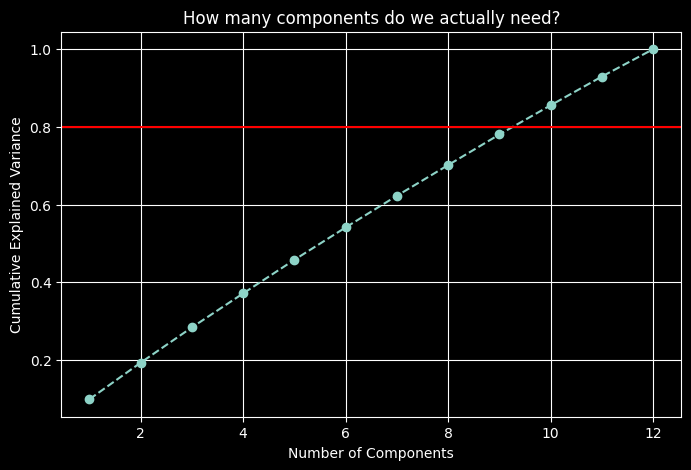

In [7]:
# Check how many components are needed to reach 80% variance
full_pca = PCA().fit(scaled_data)
cumulative_variance = np.cumsum(full_pca.explained_variance_ratio_)

# Finding the number of components for 80% threshold
n_80 = np.where(cumulative_variance >= 0.80)[0][0] + 1

logger.info(f"To explain 80% of the variance, we would need {n_80} components.")

# Plotting the "Scree Plot"
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='-')
plt.title('How many components do we actually need?')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Scree Plot & Cumulative Variance

2026-01-12 16:07:37,083 - INFO - To explain 80% of the variance, we would need 10 components.


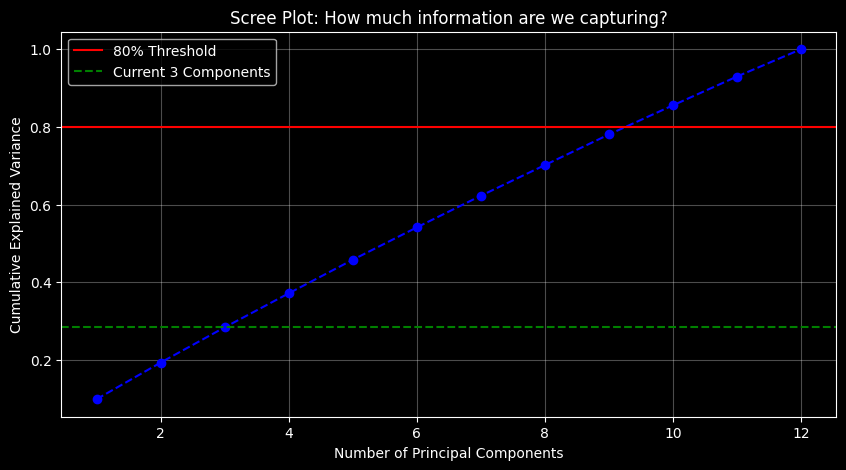

In [8]:
# 1. Run PCA without limiting the number of components to see the full picture
full_pca = PCA().fit(scaled_data)
cumulative_variance = np.cumsum(full_pca.explained_variance_ratio_)

# 2. Find exactly how many components are needed for 80% threshold
n_80 = np.where(cumulative_variance >= 0.80)[0][0] + 1
logger.info(f"To explain 80% of the variance, we would need {n_80} components.")

# 3. Visualization: The Scree Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.8, color='r', linestyle='-', label='80% Threshold')
plt.axhline(y=total_variance, color='g', linestyle='--', label='Current 3 Components')

plt.title('Scree Plot: How much information are we capturing?')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

 # 3D Visualization of Patient Profiles

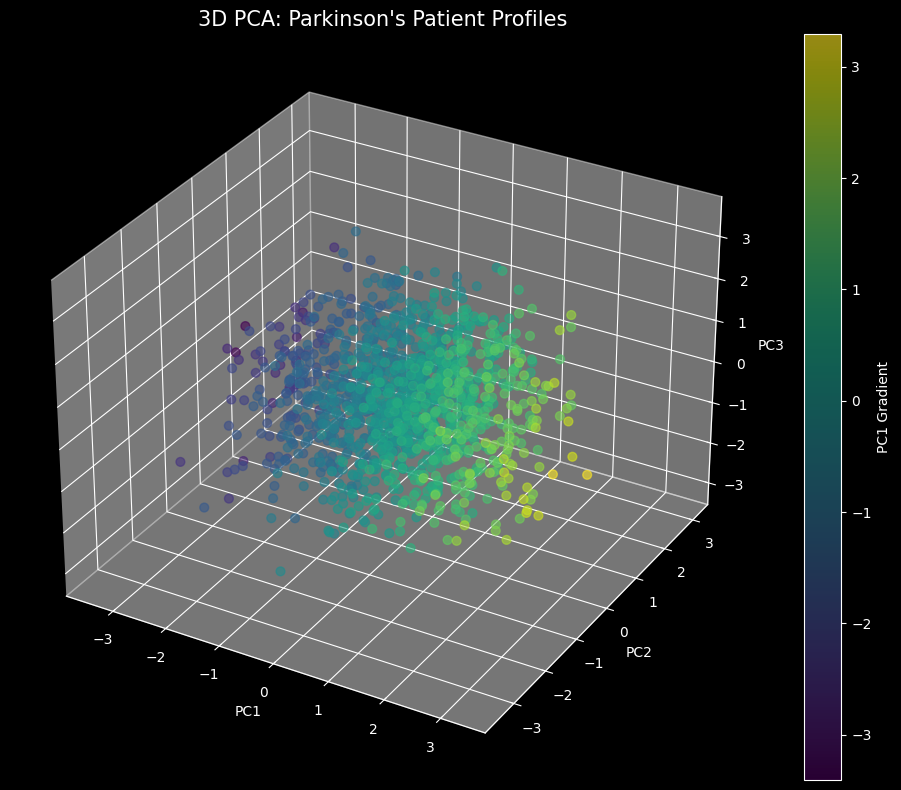

2026-01-12 16:07:37,318 - INFO - 3D Visualization created using Matplotlib.


In [9]:
import matplotlib.pyplot as plt

# 1. Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 2. Scatter plot
# c=df_pca_output['PC1'] means it will color the points by their PC1 value (looks professional)
sc = ax.scatter(df_pca_output['PC1'],
                df_pca_output['PC2'],
                df_pca_output['PC3'],
                c=df_pca_output['PC1'],
                cmap='viridis',
                s=40,
                alpha=0.6)

# 3. Labels and Title
ax.set_title("3D PCA: Parkinson's Patient Profiles", fontsize=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# 4. Add a color bar
plt.colorbar(sc, label='PC1 Gradient')

plt.tight_layout()
plt.show()

logger.info("3D Visualization created using Matplotlib.")

# The Elbow Method

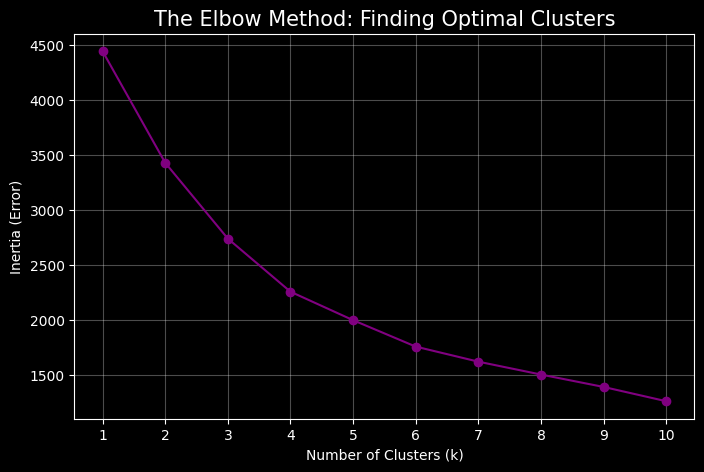

2026-01-12 16:07:37,798 - INFO - Elbow Method analysis completed.


In [10]:
from sklearn.cluster import KMeans
# 1. Calculate inertia for different numbers of clusters
inertia = []
K_range = range(1, 11) # Checking from 1 to 10 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(pca_results)
    inertia.append(km.inertia_)

# 2. Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-', color='purple')
plt.title('The Elbow Method: Finding Optimal Clusters', fontsize=15)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Error)')
plt.xticks(K_range)
plt.grid(True, alpha=0.3)

# Highlight the "Elbow"
plt.show()

logger.info("Elbow Method analysis completed.")

# K-Means Clustering

In [11]:
from sklearn.cluster import KMeans

# 1. Initialize the KMeans model
# We choose 4 clusters to look for 4 distinct patient profiles
kmeans = KMeans(n_clusters=4, random_state=42)

# 2. Fit the model using our PCA results
df_pca_output['Cluster'] = kmeans.fit_predict(pca_results)

# 3. Log the success
logger.info("Clustering complete. Patients have been assigned to 4 distinct profiles.")

# 4. Let's see how many patients are in each cluster
print(df_pca_output['Cluster'].value_counts())

2026-01-12 16:07:37,857 - INFO - Clustering complete. Patients have been assigned to 4 distinct profiles.


Cluster
2    363
1    325
0    312
3    304
Name: count, dtype: int64


# Visualizing the Clusters in 3D

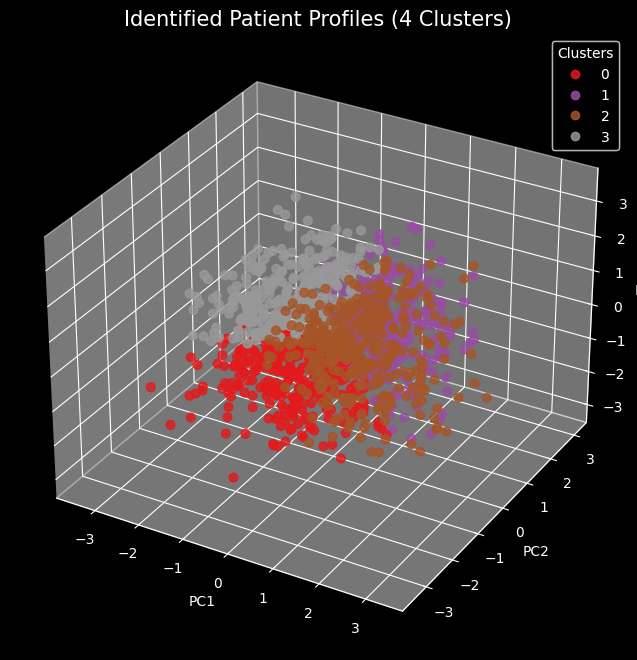

2026-01-12 16:07:38,304 - INFO - 3D Cluster Visualization created successfully.


In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Color the points by their Cluster ID (0, 1, 2)
scatter = ax.scatter(df_pca_output['PC1'],
                     df_pca_output['PC2'],
                     df_pca_output['PC3'],
                     c=df_pca_output['Cluster'], # This is the magic line!
                     cmap='Set1', # A colorful palette for distinct groups
                     s=40,
                     alpha=0.8)

ax.set_title("Identified Patient Profiles (4 Clusters)", fontsize=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Add a legend to show which color is which Cluster
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

logger.info("3D Cluster Visualization created successfully.")

# Cluster Profiling

In [19]:
# 1. Add the Cluster labels back to the ORIGINAL dataframe (the one with real units)
df_pca['Cluster'] = df_pca_output['Cluster']

# 2. Calculate the mean (average) for each variable per cluster
cluster_profiles = df_pca.groupby('Cluster').mean()

# 3. Display the results
print("Profiles for each Cluster (Mean Values):")
display(cluster_profiles)

# 4. Save the results to a CSV file to use in your presentation slides
cluster_profiles.to_csv("clusteringTA/patient_profiles_summary.csv")
logger.info("Cluster profiling complete. Summary saved to CSV.")

Profiles for each Cluster (Mean Values):


,Age,BMI,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides
Cluster,,,,,,,,,,,,
0,70.108974,30.779556,13.648003,4.531703,5.837804,7.077657,123.794872,84.910256,213.801861,111.945198,44.397440,190.353336
1,76.763077,30.201481,7.866033,6.309163,4.311340,6.396016,140.772308,100.363077,229.426332,138.170278,52.588204,254.724536
2,62.410468,22.409206,9.603002,4.621159,4.229347,6.336268,145.162534,92.592287,212.828584,125.549785,66.331076,202.040580
3,72.559211,26.808303,9.886253,4.730648,5.201040,8.089034,122.309211,80.453947,251.492599,130.731145,73.421510,252.707840


OSError: Cannot save file into a non-existent directory: 'clusteringTA'

# Creation of a heat map for clusters
We normalized the mean values across clusters using Z-score standardization to allow for a direct comparison. In this heatmap, a value of 0 represents the overall population mean. Red cells indicate values significantly above the average, while blue cells represent values below the average.

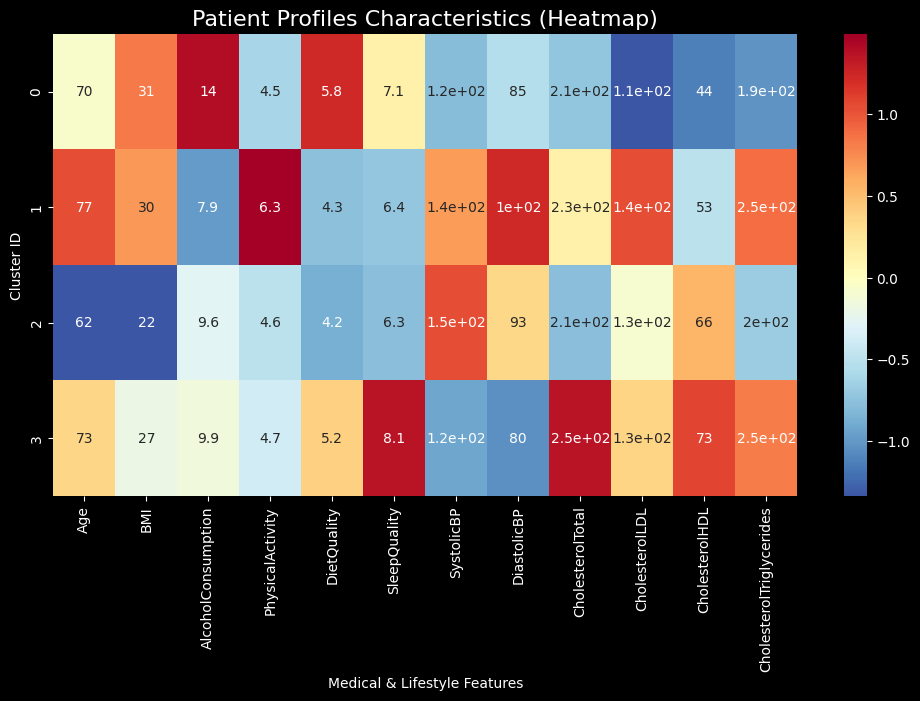

2026-01-12 16:07:40,865 - INFO - Visual profile summary created.


In [14]:
import seaborn as sns

cluster_profiles_norm = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

# Creating heat map
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles_norm, annot=cluster_profiles.round(2), cmap='RdYlBu_r', center=0)

plt.title("Patient Profiles Characteristics (Heatmap)", fontsize=16)
plt.ylabel("Cluster ID")
plt.xlabel("Medical & Lifestyle Features")
plt.show()

logger.info("Visual profile summary created.")